In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import collections
import statistics
import time
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8
# set_session(tf.Session(config=config))

C:\Users\user6\Anaconda3\envs\NP_for_test_JSD_tf13\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user6\Anaconda3\envs\NP_for_test_JSD_tf13\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user6\Anaconda3\envs\NP_for_test_JSD_tf13\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user6\Anaconda3\env

In [2]:
import gurobipy as gurobi
from gurobipy import GRB

In [3]:
print(tf.test.is_gpu_available())

True


In [4]:
# The (A)NP takes as input a `NPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tensor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

NPRegressionDescription = collections.namedtuple(
    "NPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
  """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
  """

  def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.1,
               sigma_scale=1.0,
               random_kernel_parameters=True,
               testing=False):
    """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      random_kernel_parameters: If `True`, the kernel parameters (l1 and sigma) 
          will be sampled uniformly within [0.1, l1_scale] and [0.1, sigma_scale].
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
    """
    self._batch_size = batch_size
    self._max_num_context = max_num_context
    self._x_size = x_size
    self._y_size = y_size
    self._l1_scale = l1_scale
    self._sigma_scale = sigma_scale
    self._random_kernel_parameters = random_kernel_parameters
    self._testing = testing

  def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
    """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor of shape [B, num_total_points, x_size] with
          the values of the x-axis data.
      l1: Tensor of shape [B, y_size, x_size], the scale
          parameter of the Gaussian kernel.
      sigma_f: Tensor of shape [B, y_size], the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor of shape
      [B, y_size, num_total_points, num_total_points].
    """
    num_total_points = tf.shape(xdata)[1]

    # Expand and take the difference
    xdata1 = tf.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
    xdata2 = tf.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
    diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
    norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

    norm = tf.reduce_sum(
        norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
    kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
    kernel += (sigma_noise**2) * tf.eye(num_total_points)

    return kernel

  def generate_curves(self):
    """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `NPRegressionDescription` namedtuple.
    """
    num_context = tf.random_uniform(
        shape=[], minval=3, maxval=self._max_num_context, dtype=tf.int32)

    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
    if self._testing:
      num_target = 400
      num_total_points = num_target
      x_values = tf.tile(
          tf.expand_dims(tf.range(-2., 2., 1. / 100, dtype=tf.float32), axis=0),
          [self._batch_size, 1])
      x_values = tf.expand_dims(x_values, axis=-1)
    # During training the number of target points and their x-positions are
    # selected at random
    else:
      num_target = tf.random_uniform(shape=(), minval=0, 
                                     maxval=self._max_num_context - num_context,
                                     dtype=tf.int32)
      num_total_points = num_context + num_target
      x_values = tf.random_uniform(
          [self._batch_size, num_total_points, self._x_size], -2, 2)

    # Set kernel parameters
    # Either choose a set of random parameters for the mini-batch
    if self._random_kernel_parameters:
      l1 = tf.random_uniform([self._batch_size, self._y_size,
                              self._x_size], 0.1, self._l1_scale)
      sigma_f = tf.random_uniform([self._batch_size, self._y_size],
                                  0.1, self._sigma_scale)
    # Or use the same fixed parameters for all mini-batches
    else:
      l1 = tf.ones(shape=[self._batch_size, self._y_size,
                          self._x_size]) * self._l1_scale
      sigma_f = tf.ones(shape=[self._batch_size,
                               self._y_size]) * self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
    kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
    cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
    y_values = tf.matmul(
        cholesky,
        tf.random_normal([self._batch_size, self._y_size, num_total_points, 1]))

    # [batch_size, num_total_points, y_size]
    y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

    if self._testing:
      # Select the targets
      target_x = x_values
      target_y = y_values

      # Select the observations
      idx = tf.random_shuffle(tf.range(num_target))
      context_x = tf.gather(x_values, idx[:num_context], axis=1)
      context_y = tf.gather(y_values, idx[:num_context], axis=1)

    else:
      # Select the targets which will consist of the context points as well as
      # some new target points
      target_x = x_values[:, :num_target + num_context, :]
      target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
      context_x = x_values[:, :num_context, :]
      context_y = y_values[:, :num_context, :]

    query = ((context_x, context_y), target_x)

    return NPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=tf.shape(target_x)[1],
        num_context_points=num_context)

In [5]:
# utility methods
def batch_mlp(input, output_sizes, variable_scope):
  """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).
  
  Args:
    input: input tensor of shape [B,n,d_in].
    output_sizes: An iterable containing the output sizes of the MLP as defined 
        in `basic.Linear`.
    variable_scope: String giving the name of the variable scope. If this is set
        to be the same as a previously defined MLP, then the weights are reused.
    
  Returns:
    tensor of shape [B,n,d_out] where d_out=output_sizes[-1]
  """
  # Get the shapes of the input and reshape to parallelise across observations
  batch_size, _, filter_size = input.shape.as_list()
#   batch_size = tf.shape(input)[0]
#   filter_size = tf.shape(input)[2]
  output = tf.reshape(input, (-1, filter_size))
  output.set_shape((None, filter_size))

  # Pass through MLP
  with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
    for i, size in enumerate(output_sizes[:-1]):
      output = tf.nn.relu(
          tf.layers.dense(output, size, name="layer_{}".format(i)))

    # Last layer without a ReLu
    output = tf.layers.dense(
        output, output_sizes[-1], name="layer_{}".format(i + 1))

  # Bring back into original shape
  output = tf.reshape(output, (batch_size, -1, output_sizes[-1]))
  return output

In [6]:
class DeterministicEncoder(object):
  """The Deterministic Encoder."""

  def __init__(self, output_sizes, attention):
    """(A)NP deterministic encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      attention: The attention module.
    """
    self._output_sizes = output_sizes
    self._attention = attention

  def __call__(self, context_x, context_y, target_x):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.
      target_x: Tensor of shape [B,target_observations,d_x]. 
          For this 1D regression task this corresponds to the x-values.

    Returns:
      The encoded representation. Tensor of shape [B,target_observations,d]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, 
                       "deterministic_encoder")

    # Apply attention
    with tf.variable_scope("deterministic_encoder", reuse=tf.AUTO_REUSE):
        hidden = self._attention(context_x, target_x, hidden)

    return hidden


In [7]:
class LatentEncoder(object):
  """The Latent Encoder."""

  def __init__(self, output_sizes, num_latents):
    """(A)NP latent encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      num_latents: The latent dimensionality.
    """
    self._output_sizes = output_sizes
    self._num_latents = num_latents

  def __call__(self, x, y):
    """Encodes the inputs into one representation.

    Args:
      x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.

    Returns:
      A normal distribution over tensors of shape [B, num_latents]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([x, y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, "latent_encoder")
      
    # Aggregator: take the mean over all points
    hidden = tf.reduce_mean(hidden, axis=1)
    
    # Have further MLP layers that map to the parameters of the Gaussian latent
    with tf.variable_scope("latent_encoder", reuse=tf.AUTO_REUSE):
      # First apply intermediate relu layer 
      hidden = tf.nn.relu(
          tf.layers.dense(hidden, 
                          (self._output_sizes[-1] + self._num_latents)/2, 
                          name="penultimate_layer"))
      # Then apply further linear layers to output latent mu and log sigma
      mu = tf.layers.dense(hidden, self._num_latents, name="mean_layer")
      log_sigma = tf.layers.dense(hidden, self._num_latents, name="std_layer")
      
    # Compute sigma
    sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)

    return tf.contrib.distributions.Normal(loc=mu, scale=sigma)


In [8]:
class Decoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """(A)NP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x):
    """Decodes the individual targets.

    Args:
      representation: The representation of the context for target predictions. 
          Tensor of shape [B,target_observations,?].
      target_x: The x locations for the target query.
          Tensor of shape [B,target_observations,d_x].

    Returns:
      dist: A multivariate Gaussian over the target points. A distribution over
          tensors of shape [B,target_observations,d_y].
      mu: The mean of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
      sigma: The standard deviation of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
    """
    # concatenate target_x and representation
    hidden = tf.concat([representation, target_x], axis=-1)
    
    # Pass final axis through MLP
    hidden = batch_mlp(hidden, self._output_sizes, "decoder")

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

In [9]:
class LatentModel(object):
    """The (A)NP model."""

    def __init__(self, latent_encoder_output_sizes, num_latents,
               decoder_output_sizes, use_deterministic_path=True, 
               deterministic_encoder_output_sizes=None, attention=None):
        """Initialises the model.

        Args:
          latent_encoder_output_sizes: An iterable containing the sizes of hidden 
              layers of the latent encoder.
          num_latents: The latent dimensionality.
          decoder_output_sizes: An iterable containing the sizes of hidden layers of
              the decoder. The last element should correspond to d_y * 2
              (it encodes both mean and variance concatenated)
          use_deterministic_path: a boolean that indicates whether the deterministic
              encoder is used or not.
          deterministic_encoder_output_sizes: An iterable containing the sizes of 
              hidden layers of the deterministic encoder. The last one is the size 
              of the deterministic representation r.
          attention: The attention module used in the deterministic encoder.
              Only relevant when use_deterministic_path=True.
        """
        self._latent_encoder = LatentEncoder(latent_encoder_output_sizes, 
                                             num_latents)
        self._decoder = Decoder(decoder_output_sizes)
        self._use_deterministic_path = use_deterministic_path
        if use_deterministic_path:
            self._deterministic_encoder = DeterministicEncoder(
              deterministic_encoder_output_sizes, attention)


    def __call__(self, query, num_targets, target_y=None):
        """Returns the predicted mean and variance at the target points.

        Args:
          query: Array containing ((context_x, context_y), target_x) where:
              context_x: Tensor of shape [B,num_contexts,d_x]. 
                  Contains the x values of the context points.
              context_y: Tensor of shape [B,num_contexts,d_y]. 
                  Contains the y values of the context points.
              target_x: Tensor of shape [B,num_targets,d_x]. 
                  Contains the x values of the target points.
          num_targets: Number of target points.
          target_y: The ground truth y values of the target y. 
              Tensor of shape [B,num_targets,d_y].

        Returns:
          log_p: The log_probability of the target_y given the predicted
              distribution. Tensor of shape [B,num_targets].
          mu: The mean of the predicted distribution. 
              Tensor of shape [B,num_targets,d_y].
          sigma: The variance of the predicted distribution.
              Tensor of shape [B,num_targets,d_y].
        """

        (context_x, context_y), target_x = query

        # Pass query through the encoder and the decoder
        prior = self._latent_encoder(context_x, context_y)

        # For training, when target_y is available, use targets for latent encoder.
        # Note that targets contain contexts by design.
        if target_y is None:
            latent_rep = prior.sample()
        # For testing, when target_y unavailable, use contexts for latent encoder.
        else:
            posterior = self._latent_encoder(target_x, target_y)
            latent_rep = posterior.sample()
        latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                             [1, num_targets, 1])
        if self._use_deterministic_path:
            deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                          target_x)
            representation = tf.concat([deterministic_rep, latent_rep], axis=-1)
        else:
            representation = latent_rep

        dist, mu, sigma = self._decoder(representation, target_x)

        # If we want to calculate the log_prob for training we will make use of the
        # target_y. At test time the target_y is not available so we return None.
        if target_y is not None:
            log_p = dist.log_prob(target_y)
            posterior = self._latent_encoder(target_x, target_y)
            kl = tf.reduce_sum(
              tf.contrib.distributions.kl_divergence(posterior, prior), 
              axis=-1, keepdims=True)
            kl = tf.tile(kl, [1, num_targets])
            loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
            
        else:
            log_p = None
            kl = None
            loss = None

        return mu, sigma, log_p, kl, loss


In [10]:
def uniform_attention(q, v):
  """Uniform attention. Equivalent to np.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    v: values. tensor of shape [B,n,d_v].
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  total_points = tf.shape(q)[1]
  rep = tf.reduce_mean(v, axis=1, keepdims=True)  # [B,1,d_v]
  rep = tf.tile(rep, [1, total_points, 1])
  return rep

def laplace_attention(q, k, v, scale, normalise):
  """Computes laplace exponential attention.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    scale: float that scales the L1 distance.
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  k = tf.expand_dims(k, axis=1)  # [B,1,n,d_k]
  q = tf.expand_dims(q, axis=2)  # [B,m,1,d_k]
  unnorm_weights = - tf.abs((k - q) / scale)  # [B,m,n,d_k]
  unnorm_weights = tf.reduce_sum(unnorm_weights, axis=-1)  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = lambda x: 1 + tf.tanh(x)
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def dot_product_attention(q, k, v, normalise):
  """Computes dot product attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = tf.shape(q)[-1]
  scale = tf.sqrt(tf.cast(d_k, tf.float32))
  unnorm_weights = tf.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = tf.sigmoid
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def multihead_attention(q, k, v, num_heads=8):
  """Computes multi-head attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    num_heads: number of heads. Should divide d_v.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = q.get_shape().as_list()[-1]
  d_v = v.get_shape().as_list()[-1]
  head_size = d_v / num_heads
  key_initializer = tf.random_normal_initializer(stddev=d_k**-0.5)
  value_initializer = tf.random_normal_initializer(stddev=d_v**-0.5)
  rep = tf.constant(0.0)
  for h in range(num_heads):
    o = dot_product_attention(
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wq%d' % h, use_bias=False, padding='VALID')(q),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wk%d' % h, use_bias=False, padding='VALID')(k),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wv%d' % h, use_bias=False, padding='VALID')(v),
        normalise=True)
    rep += tf.layers.Conv1D(d_v, 1, kernel_initializer=value_initializer,
                      name='wo%d' % h, use_bias=False, padding='VALID')(o)
  return rep

class Attention(object):
  """The Attention module."""

  def __init__(self, rep, output_sizes, att_type, scale=1., normalise=True,
               num_heads=8):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention. 
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalise: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self._rep = rep
    self._output_sizes = output_sizes
    self._type = att_type
    self._scale = scale
    self._normalise = normalise
    if self._type == 'multihead':
      self._num_heads = num_heads

  def __call__(self, x1, x2, r):
    """Apply attention to create aggregated representation of r.

    Args:
      x1: tensor of shape [B,n1,d_x].
      x2: tensor of shape [B,n2,d_x].
      r: tensor of shape [B,n1,d].
      
    Returns:
      tensor of shape [B,n2,d]

    Raises:
      NameError: The argument for rep/type was invalid.
    """
    if self._rep == 'identity':
      k, q = (x1, x2)
    elif self._rep == 'mlp':
      # Pass through MLP
      k = batch_mlp(x1, self._output_sizes, "attention")
      q = batch_mlp(x2, self._output_sizes, "attention")
    else:
      raise NameError("'rep' not among ['identity','mlp']")

    if self._type == 'uniform':
      rep = uniform_attention(q, r)
    elif self._type == 'laplace':
      rep = laplace_attention(q, k, r, self._scale, self._normalise)
    elif self._type == 'dot_product':
      rep = dot_product_attention(q, k, r, self._normalise)
    elif self._type == 'multihead':
      rep = multihead_attention(q, k, r, self._num_heads)
    else:
      raise NameError(("'att_type' not among ['uniform','laplace','dot_product'"
                       ",'multihead']"))

    return rep

In [11]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
  """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
  """
  # Plot everything
  plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
  plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
  plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
  plt.fill_between(
      target_x[0, :, 0],
      pred_y[0, :, 0] - std[0, :, 0],
      pred_y[0, :, 0] + std[0, :, 0],
      alpha=0.2,
      facecolor='#65c9f7',
      interpolate=True)

  # Make the plot pretty
  plt.yticks([-2, 0, 2], fontsize=16)
  plt.xticks([-2, 0, 2], fontsize=16)
  plt.ylim([-2, 2])
  plt.grid('off')
  ax = plt.gca()
  plt.show()

In [13]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 100 #@param {type:"number"}
PLOT_AFTER = 1000
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters = False #@param {type:"boolean"}

tf.reset_default_graph()


In [14]:
# Test dataset
dataset_test = GPCurvesReader(
    batch_size=10, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=False, testing=True)
data_test = dataset_test.generate_curves()


# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type=ATTENTION_TYPE)
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

optimizer = tf.train.AdamOptimizer(1e-3)

# input length scale to create data
ls_input = tf.placeholder(tf.float32, shape=())
dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, l1_scale=ls_input, random_kernel_parameters=False)
data_train = dataset_train.generate_curves()

target_y_1 = data_train.target_y
query_1 = data_train.query
data_train_num_total_points_1 = data_train.num_total_points

# inner update for the input length scale
_, _, log_prob_1, _, loss_1 = model(query_1, data_train_num_total_points_1, target_y_1)

inner_train_step_anp = optimizer.minimize(loss_1)


# to evalute gradient for outer update
with tf.control_dependencies([inner_train_step_anp]) :
    dataset_train_out = GPCurvesReader(
        batch_size=16, max_num_context=MAX_CONTEXT_POINTS, l1_scale=ls_input, random_kernel_parameters=False)
    data_train_out = dataset_train_out.generate_curves()
    
    target_y_out = data_train_out.target_y
    query_out = data_train_out.query
    data_train_num_total_points_out = data_train_out.num_total_points
    
    _, _, cur_log_prob_out, _, cur_loss_out = model(query_out, data_train_num_total_points_out,
                                         target_y_out)

    cur_grad_and_var_anp = optimizer.compute_gradients(cur_loss_out)

# outer update
tvars = tf.trainable_variables()
anp_grad_avg_list = []
for var_idx, var in enumerate(tvars) : 
    globals()['anp_grad_avg_' + str(var_idx)] = tf.placeholder(tf.float32)
    anp_grad_avg_list.append(globals()['anp_grad_avg_' + str(var_idx)])
outer_train_step = optimizer.apply_gradients(zip(anp_grad_avg_list, tvars))


# test, Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, loss_test = model(data_test.query, data_test.num_total_points, data_test.target_y)
test_train_step = optimizer.minimize(loss_test)

# reset variables (theta)
var_list = tf.trainable_variables()
var_value = tf.placeholder(tf.float32)
for var_idx, var in enumerate(var_list) : 
    globals()['reset_theta_' + str(var_idx)] = tf.assign(var, var_value)

init = tf.global_variables_initializer()


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should updat

In [15]:
len(tf.trainable_variables())

64

In [17]:
def reset_theta(theta) : 
    theta_new = tf.trainable_variables()
    for var_idx, var in enumerate(theta_new) : 
        sess.run(globals()['reset_theta_' + str(var_idx)], feed_dict={var_value : theta[var_idx]})
    

In [18]:
ewma_value = 0
ewma_list = []

Iteration: 0, loss: 1.4638193845748901


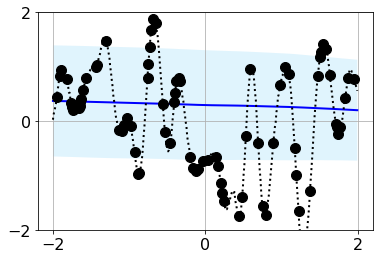

prob_domain =  [0.16996876808096537, 0.163364565252368, 0.16996876808096537, 0.163364565252368, 0.163364565252368, 0.16996876808096537]
interval_low_idx_list =  [2, 0, 5]
Iteration: 1000, loss: 1.3050715923309326


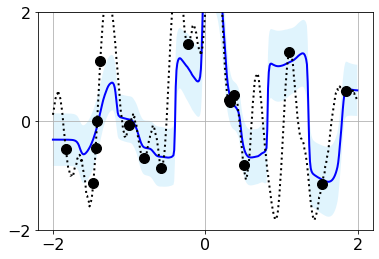

prob_domain =  [0.22000315560039868, 0.16733420719769257, 0.16333511230367392, 0.1680073473938484, 0.1418860845384681, 0.13943409296591835]
interval_low_idx_list =  [5, 1, 3]
Iteration: 2000, loss: 1.7372294664382935


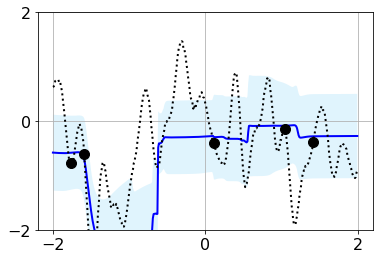

prob_domain =  [0.20802331099223018, 0.21287724920283205, 0.1780676809479103, 0.146475570569387, 0.13831674129323693, 0.1162394469944036]
interval_low_idx_list =  [2, 5, 1]
Iteration: 3000, loss: 1.7811577320098877


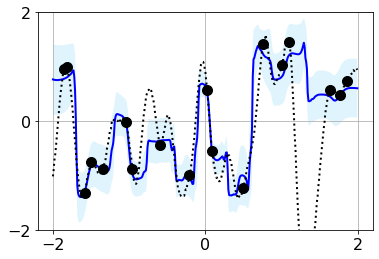

prob_domain =  [0.23827301223148362, 0.17416522691662764, 0.19232131066374997, 0.1609796907930786, 0.1165434809445563, 0.11771727845050388]
interval_low_idx_list =  [0, 4, 2]
Iteration: 4000, loss: 1.4165748357772827


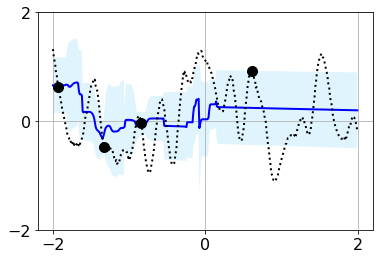

prob_domain =  [0.28988165836034646, 0.2085131159121002, 0.1597145086687265, 0.1634710245937338, 0.0971861132719139, 0.08123357919317924]
interval_low_idx_list =  [3, 4, 1]
Iteration: 5000, loss: 1.5802608728408813


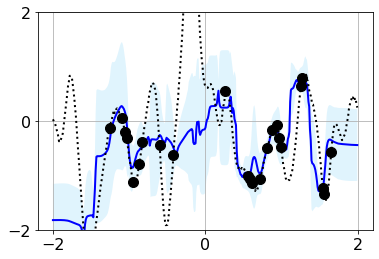

prob_domain =  [0.5184847988566751, 0.2827302984670217, 0.12695090981440169, 0.07084934928132124, 0.0, 0.0009846435805803925]
interval_low_idx_list =  [3, 3, 0]
Iteration: 6000, loss: 0.19918352365493774


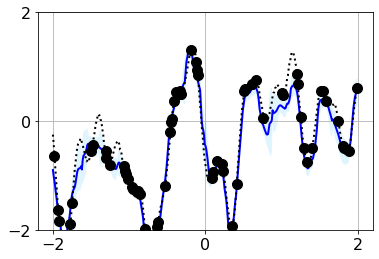

prob_domain =  [0.7698017842882953, 0.22658281279176748, 0.0, 0.0, 0.003615402919937237, 0.0]
interval_low_idx_list =  [4, 4, 4]
Iteration: 7000, loss: 0.31262603402137756


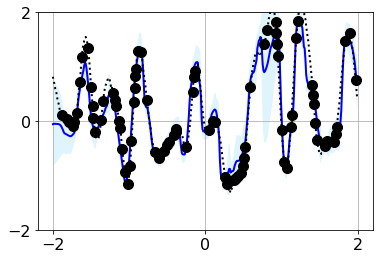

prob_domain =  [0.9994659154661083, 0.0, 0.0, 0.0, 0.0, 0.000534084533891627]
interval_low_idx_list =  [5, 4, 1]
Iteration: 8000, loss: 0.2157309353351593


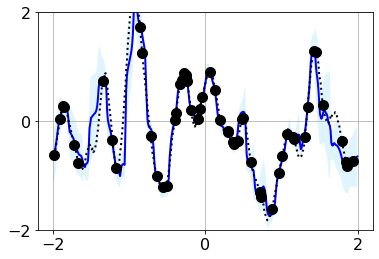

prob_domain =  [0.9942000138045625, 0.005799986195437586, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [1, 1, 0]
Iteration: 9000, loss: 0.4594510495662689


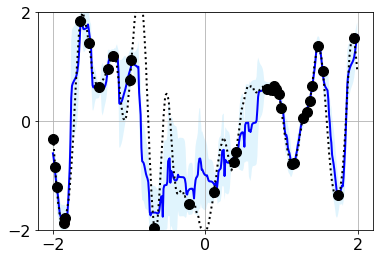

prob_domain =  [0.9962630730686924, 0.0006756666799306306, 0.0030612602513768257, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 4, 4]
Iteration: 10000, loss: -0.4392966330051422


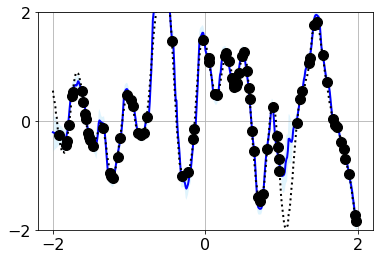

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [5, 4, 3]
Iteration: 11000, loss: 1.3334389925003052


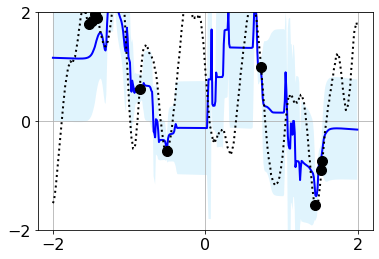

prob_domain =  [0.9956626889157332, 0.004110265253708302, 0.0, 0.0, 0.0, 0.00022704583055850152]
interval_low_idx_list =  [4, 4, 3]
Iteration: 12000, loss: 0.19360490143299103


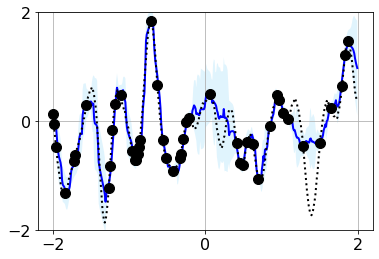

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [5, 0, 5]
Iteration: 13000, loss: -0.13759320974349976


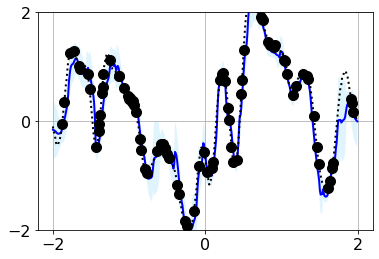

prob_domain =  [0.9996088856326741, 0.0, 0.00039111436732594947, 0.0, 0.0, 0.0]
interval_low_idx_list =  [5, 0, 1]
Iteration: 14000, loss: 0.4126533269882202


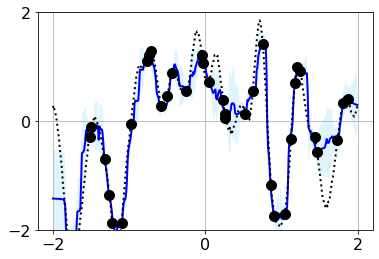

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 3, 1]
Iteration: 15000, loss: 1.1435495615005493


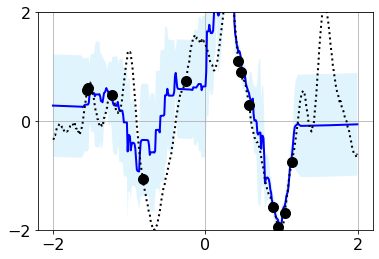

prob_domain =  [0.9984999438032014, 0.0, 0.0015000561967985645, 0.0, 0.0, 0.0]
interval_low_idx_list =  [1, 4, 4]
Iteration: 16000, loss: 0.642453670501709


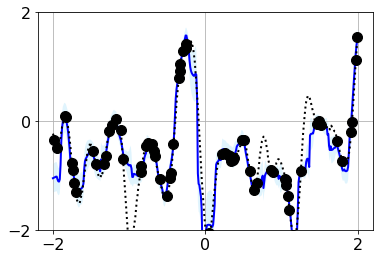

prob_domain =  [0.9868112995468528, 0.0016627425396310797, 0.005715367760648934, 0.002417583611963757, 0.00018319746713608441, 0.0032098090737674744]
interval_low_idx_list =  [1, 4, 4]
Iteration: 17000, loss: 0.5750337243080139


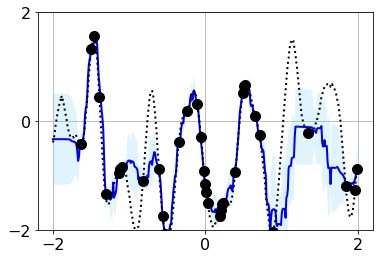

prob_domain =  [0.9994602045224941, 0.0005397954775059472, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 5, 3]
Iteration: 18000, loss: 0.39613568782806396


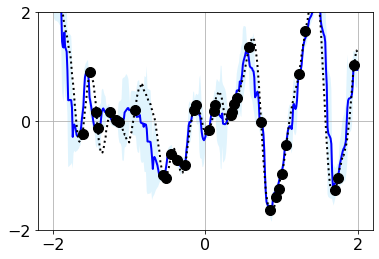

prob_domain =  [0.9968722626333454, 0.0015638686833272881, 0.0015638686833272881, 0.0, 0.0, 0.0]
interval_low_idx_list =  [0, 5, 5]
Iteration: 19000, loss: -0.2565925717353821


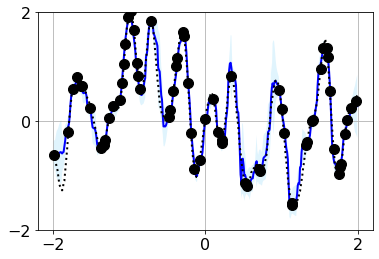

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 5, 3]
Iteration: 20000, loss: -0.6521042585372925


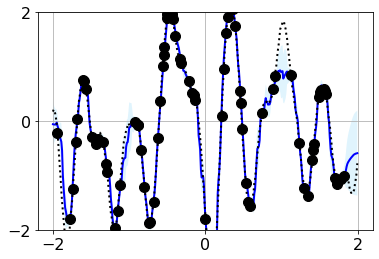

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 2, 3]
Iteration: 21000, loss: -0.09143596142530441


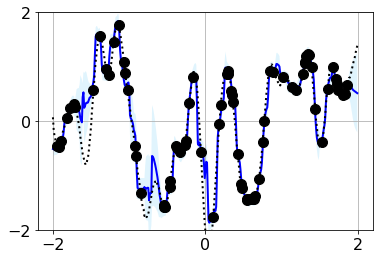

prob_domain =  [0.9938592615690859, 0.005366679589000385, 0.0, 0.0, 0.000774058841913819, 0.0]
interval_low_idx_list =  [0, 0, 1]
Iteration: 22000, loss: 0.7819299697875977


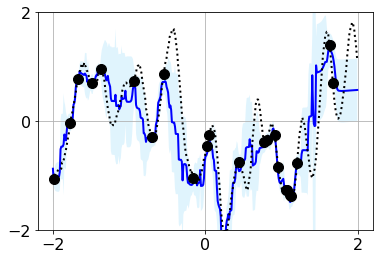

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 0, 3]
Iteration: 23000, loss: 0.05568050220608711


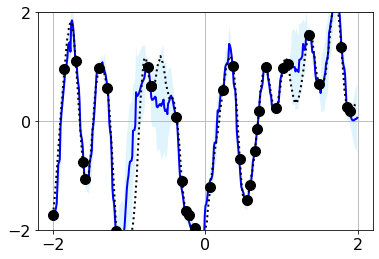

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [2, 3, 3]
Iteration: 24000, loss: 1.0942779779434204


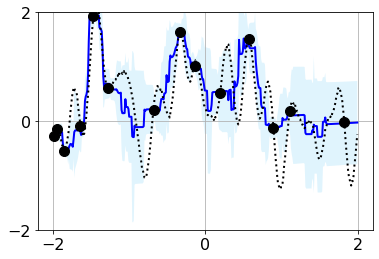

prob_domain =  [0.9964099351259091, 0.0001396956903129327, 0.00345036918377797, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 5, 3]
Iteration: 25000, loss: -0.5617877244949341


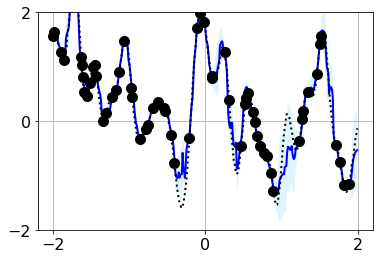

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 1, 2]
Iteration: 26000, loss: 1.16090989112854


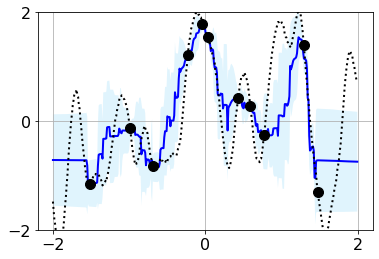

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 3, 2]
Iteration: 27000, loss: 0.17390228807926178


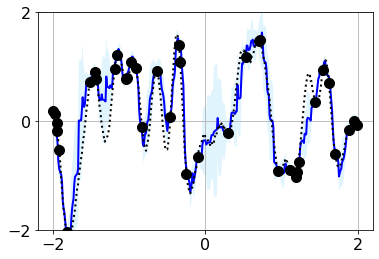

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [5, 3, 1]
Iteration: 28000, loss: -0.2631388306617737


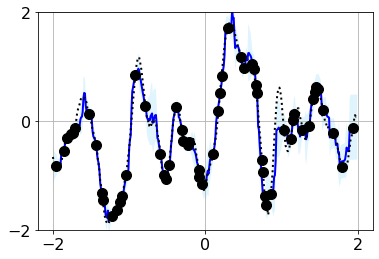

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [5, 0, 0]
Iteration: 29000, loss: 1.2956675291061401


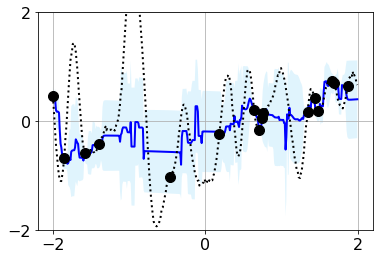

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [1, 2, 2]
Iteration: 30000, loss: 0.03589877486228943


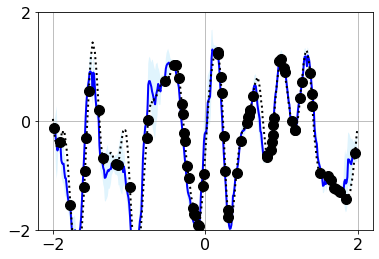

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 3, 3]
Iteration: 31000, loss: -0.2645653486251831


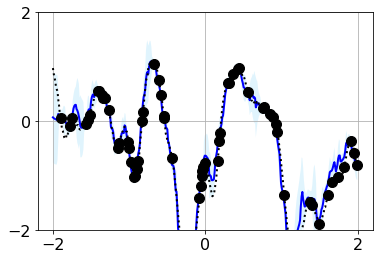

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [0, 4, 1]
Iteration: 32000, loss: 0.22415503859519958


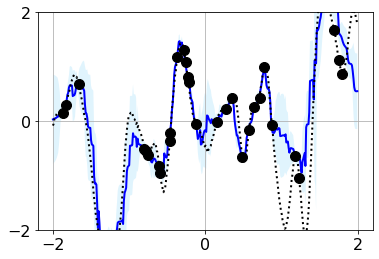

prob_domain =  [0.9990240298432751, 0.0004879850783624874, 0.0004879850783624874, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 4, 5]
Iteration: 33000, loss: -0.2642514705657959


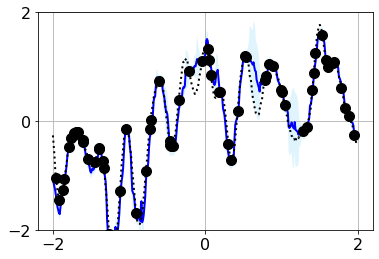

prob_domain =  [0.997637323184495, 0.0, 0.0011813384077525731, 0.0011813384077525731, 0.0, 0.0]
interval_low_idx_list =  [3, 2, 0]
Iteration: 34000, loss: -0.5428710579872131


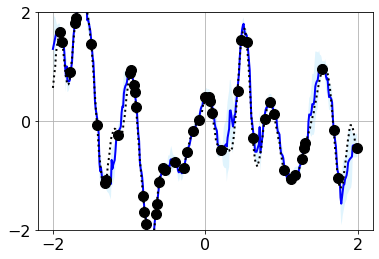

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [2, 3, 5]
Iteration: 35000, loss: 0.3452723026275635


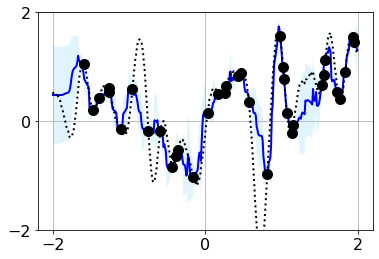

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 4, 2]
Iteration: 36000, loss: 0.6105836629867554


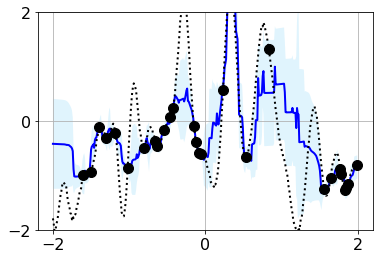

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [2, 3, 4]
Iteration: 37000, loss: 1.2064522504806519


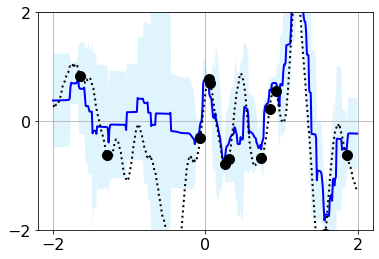

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [2, 3, 2]
Iteration: 38000, loss: 0.601628303527832


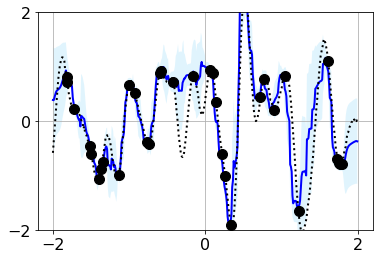

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [1, 2, 3]
Iteration: 39000, loss: 0.47453033924102783


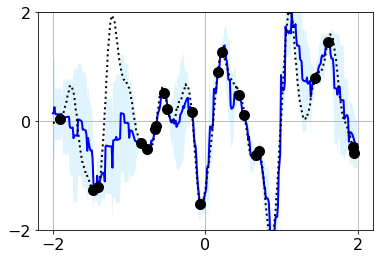

prob_domain =  [0.997910273009744, 0.0, 0.002089726990255983, 0.0, 0.0, 0.0]
interval_low_idx_list =  [0, 5, 2]
Iteration: 40000, loss: 1.3470016717910767


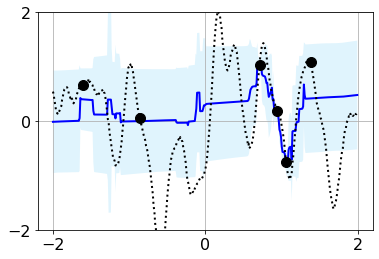

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [1, 4, 2]
Iteration: 41000, loss: 0.1464524269104004


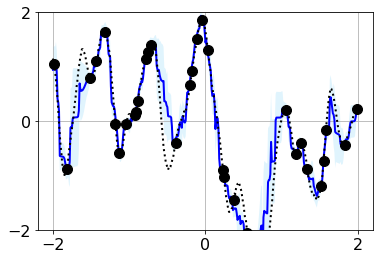

prob_domain =  [0.9981770190458439, 0.0012274849159394953, 0.0, 0.0, 0.0005954960382166804, 0.0]
interval_low_idx_list =  [3, 2, 3]
Iteration: 42000, loss: 0.5411355495452881


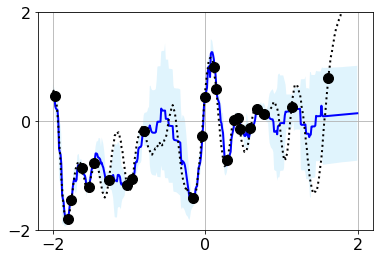

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [2, 5, 4]
Iteration: 43000, loss: 1.1655157804489136


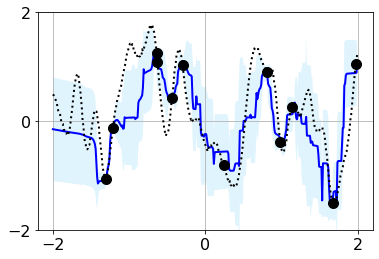

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [5, 2, 3]
Iteration: 44000, loss: 0.24351823329925537


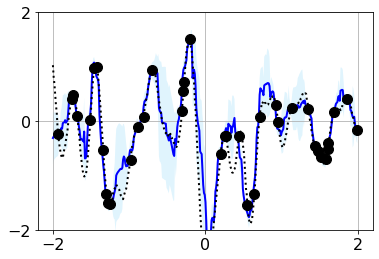

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [0, 0, 4]
Iteration: 45000, loss: -0.28697067499160767


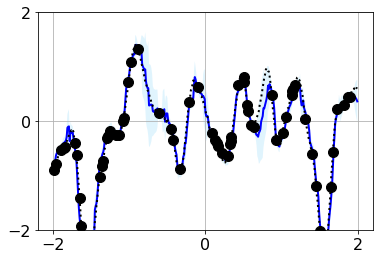

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [0, 1, 4]
Iteration: 46000, loss: -0.7844218611717224


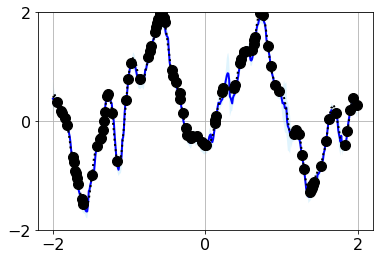

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [2, 3, 2]
Iteration: 47000, loss: -0.3576166331768036


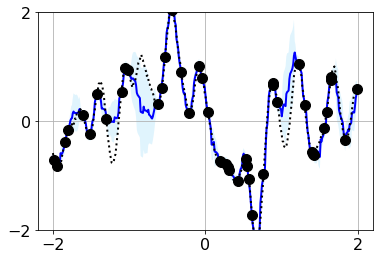

prob_domain =  [0.9975892044147833, 0.0, 0.0008035985284055904, 0.0, 0.0016071970568111809, 0.0]
interval_low_idx_list =  [4, 4, 2]
Iteration: 48000, loss: 0.023042481392621994


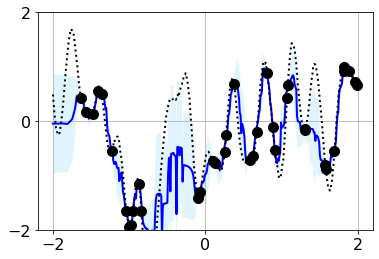

prob_domain =  [0.995864255878371, 0.002191950818410851, 0.0016993532873811057, 0.0, 0.0, 0.0002444400158371367]
interval_low_idx_list =  [4, 3, 0]
Iteration: 49000, loss: -0.8104457259178162


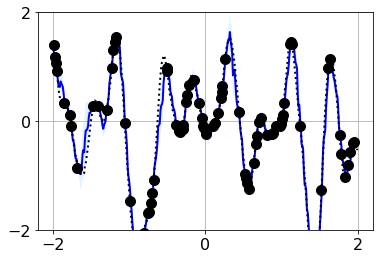

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 4, 1]
Iteration: 50000, loss: 1.045767903327942


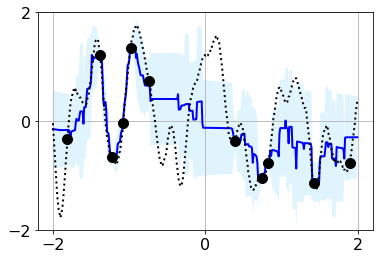

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [2, 0, 2]
Iteration: 51000, loss: -0.08006783574819565


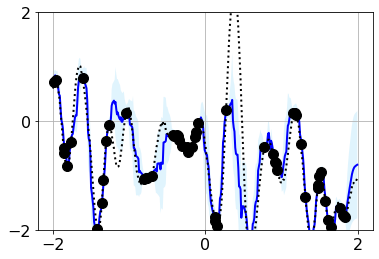

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [0, 5, 3]
Iteration: 52000, loss: -0.8594889044761658


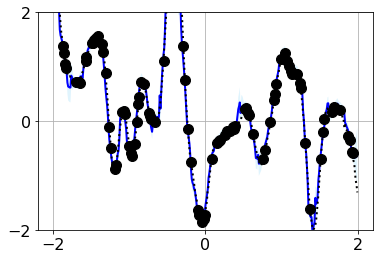

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 2, 1]
Iteration: 53000, loss: -0.21369382739067078


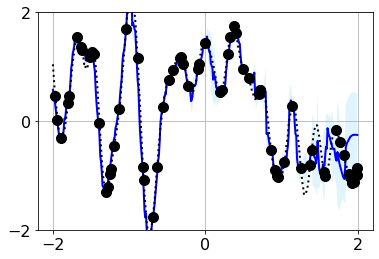

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 0, 0]
Iteration: 54000, loss: 0.17340227961540222


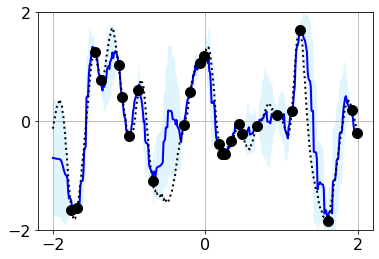

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [1, 2, 1]
Iteration: 55000, loss: -0.6099985241889954


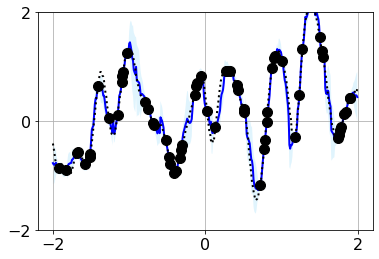

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 0, 2]
Iteration: 56000, loss: -0.6201370358467102


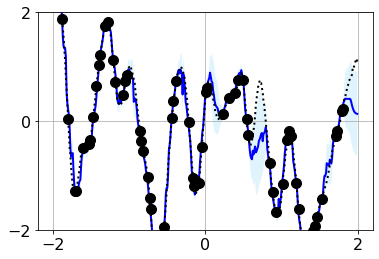

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [1, 3, 4]
Iteration: 57000, loss: -0.09281692653894424


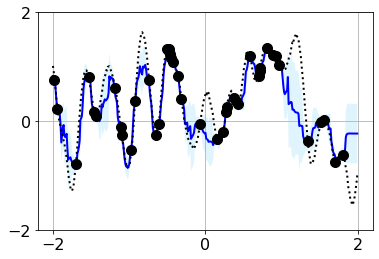

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 1, 4]
Iteration: 58000, loss: -0.3175432085990906


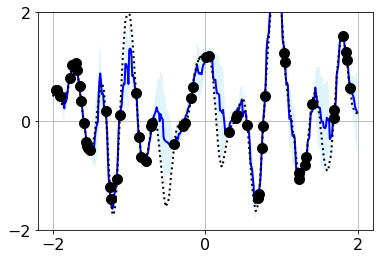

prob_domain =  [0.9990582452368549, 0.0, 0.0, 0.0, 0.0009417547631450357, 0.0]
interval_low_idx_list =  [3, 5, 5]
Iteration: 59000, loss: -0.8005232214927673


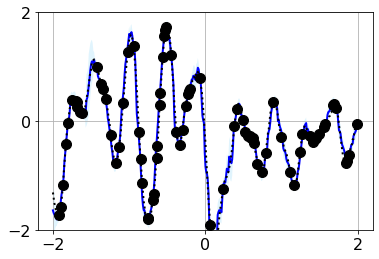

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 1, 1]
Iteration: 60000, loss: -0.5645870566368103


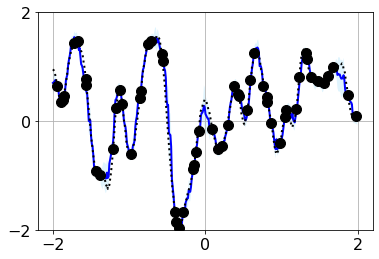

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 5, 1]
Iteration: 61000, loss: -0.27348417043685913


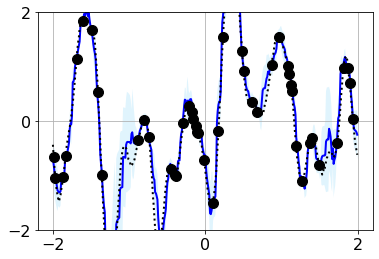

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [0, 4, 4]
Iteration: 62000, loss: 1.1476705074310303


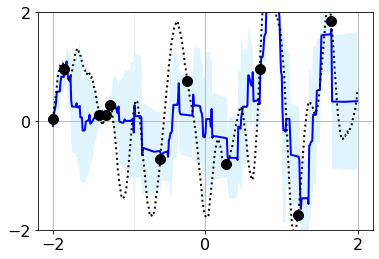

prob_domain =  [0.9984585148810656, 0.0, 0.0, 0.0015414851189344664, 0.0, 0.0]
interval_low_idx_list =  [5, 1, 5]
Iteration: 63000, loss: -0.6964579820632935


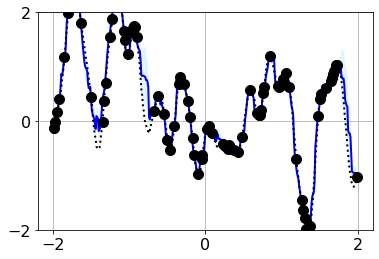

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [3, 3, 4]
Iteration: 64000, loss: 0.49828675389289856


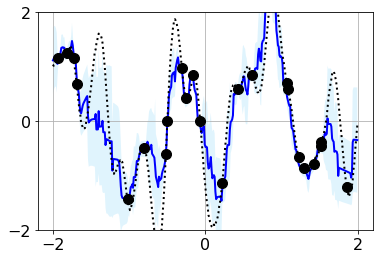

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [0, 0, 3]
Iteration: 65000, loss: -0.04768671840429306


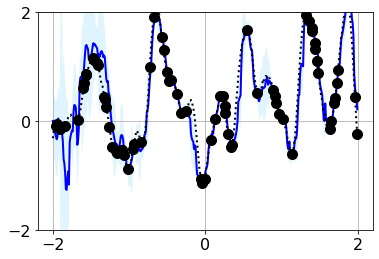

prob_domain =  [0.9957701629391298, 0.0, 0.004229837060870206, 0.0, 0.0, 0.0]
interval_low_idx_list =  [2, 2, 2]
Iteration: 66000, loss: -0.6129215955734253


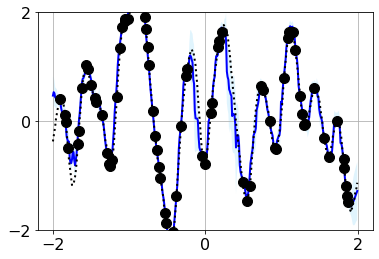

prob_domain =  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
interval_low_idx_list =  [4, 1, 2]


In [20]:
# Train and plot
time_start = time.time()
sess = tf.Session() 
sess.run(init)

training_ls_list = []
cur_loss_list = []

ls_domain = [0.05, 0.075, 0.1125, 0.16875, 0.253125, 0.3796875, 0.56953125]
prob_domain = [1 / len(ls_domain) for _ in range(len(ls_domain)- 1 )] # 因為是每個區間的機率，所以用len - 1(在抽區間LOW的時候也是只抽前六個)
lr_prob = 5e-4

TRAINING_ITERATIONS_TMP = 66666
for it in range(TRAINING_ITERATIONS_TMP):
    trainable_vars = tf.trainable_variables()
    theta = [var.eval(session=sess) for var in trainable_vars]

    dist_inner_grad_list = []
    anp_inner_grad_list = []

    interval_low_idx_list = []
    # inner update three times
    for inner_it in range(3) : 
        # sample length scale
        interval_cur_low_idx = np.random.choice(range(len(ls_domain) - 1))
        interval_low_idx_list.append(interval_cur_low_idx)
        ls_cur = np.random.uniform(low=ls_domain[interval_cur_low_idx], high=ls_domain[interval_cur_low_idx + 1])
        
        # inner update
        _, cur_loss_value, cur_grad_and_var_anp_value = sess.run(
            [inner_train_step_anp, cur_loss_out, cur_grad_and_var_anp], feed_dict={ls_input : ls_cur})

        anp_inner_grad_list.append(cur_grad_and_var_anp_value)
        training_ls_list.append(ls_cur)
        cur_loss_list.append(cur_loss_value)
        reset_theta(theta)
        
    ### compute gp_hat (to update the hyperparameter p) ###
    gp_hat = (len(ls_domain) / 3) * sum(cur_loss_list[-3:])
    for interval_low_used in interval_low_idx_list : 
        prob_new = prob_domain[interval_low_used] + lr_prob * gp_hat
        prob_domain[interval_low_used] = prob_new
        # Here must use projection theoretically. But I just use a ReLU to avoid the parameter p from negative value.
        if prob_new >= 0 : 
            prob_domain[interval_low_used] = prob_new
        elif prob_new < 0 : 
            prob_domain[interval_low_used] = 0
        
    prob_sum = sum(prob_domain)
    for p_idx, p_item in enumerate(prob_domain) : 
        prob_domain[p_idx] = p_item / prob_sum

    ### test part ###
    for _ in range(3) : # 3 means fine tune 3 times. You can decide how many times you want to fine tune.
        sess.run(test_train_step)
    loss_test_value, pred_y, std_y, target_y, whole_query = sess.run(
              [loss_test, mu, sigma, data_test.target_y, 
               data_test.query])

    ewma_value = 0.99 * ewma_value + (1 - 0.99) * loss_test_value
    ewma_list.append(ewma_value)

    if it % PLOT_AFTER == 0 : 
        (context_x, context_y), target_x = whole_query
        print('Iteration: {}, loss: {}'.format(it, loss_test_value))
        plot_functions(target_x, target_y, context_x, context_y, pred_y, std_y)
        print('prob_domain = ', prob_domain)
        print('interval_low_idx_list = ', interval_low_idx_list)


    ### gradient for outer update ###
    grad_avg_dic = {}
    for grad_idx, (g_and_v_1, g_and_v_2, g_and_v_3) in enumerate(zip(anp_inner_grad_list[0], anp_inner_grad_list[1], anp_inner_grad_list[2])) : 
        grad_avg_dic[globals()['anp_grad_avg_' + str(grad_idx)]] = prob_domain[interval_low_idx_list[0]]*g_and_v_1[0] + prob_domain[interval_low_idx_list[1]]*g_and_v_2[0] + prob_domain[interval_low_idx_list[2]]*g_and_v_3[0] ### p_n * grad_n
    
    reset_theta(theta)
    sess.run(outer_train_step, feed_dict=grad_avg_dic)
    
time_end = time.time()

In [24]:
print((time_end - time_start) / 60)

281.11314942439395


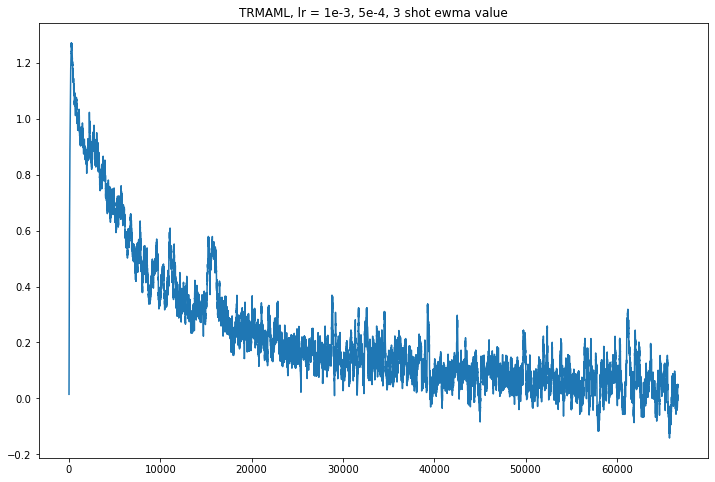

In [25]:
### plot the ewma
plt.figure(figsize=(12, 8))
plt.title('TRMAML, lr = 1e-3, 5e-4, 3 shot ewma value')
plt.plot(ewma_list)

In [30]:
saver = tf.train.Saver()
saver.save(sess, 'D:/hw/meeting/neural-processes-master/save_anp_models/MAML_ANP_lr_(1e-3, 5e-4)_TRMAML-setting(ls_interval, obj no avg)_200k_batch_16_uniform_sample_ver')


'D:/hw/meeting/neural-processes-master/save_anp_models/MAML_ANP_lr_(1e-3, 5e-4)_TRMAML-setting(ls_interval, obj no avg)_200k_batch_16_uniform_sample_ver'